# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV96"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [5]:
# OUTPUT_FIGURES_DIR = Path(
#     conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
# ).resolve()
# display(OUTPUT_FIGURES_DIR)
# OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
# display(OUTPUT_CELL_TYPE_FILEPATH)

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases/phenoplier/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-09-29 10:41:48,602 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
414,SVM T cells follicular helper,96,0.689263,0.004435,0.024527
415,SVM NK cells activated,96,0.729687,0.000274,0.002569


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP060416, SRP056049, SRP005279, SRP055569, SRP064464, SRP057196, SRP042161, SRP014428, SRP018853, SRP024268, SRP050499, SRP066834, 

In [19]:
lv_data.shape

(3985, 29)

In [20]:
lv_data.head()

tonsil donor facs gating                     cell type  \
project   run                                                                 
SRP060416 SRR2088096    Donor T74          NK  tonsil Innate lymphoid cells   
          SRR2088128    Donor T74        ILC3  tonsil Innate lymphoid cells   
          SRR2088153    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088179    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088205    Donor T75        ILC3  tonsil Innate lymphoid cells   

                     diagnosis cell population all lineage bcp all subtype  \
project   run                                                                
SRP060416 SRR2088096       NaN             NaN         NaN             NaN   
          SRR2088128       NaN             NaN         NaN             NaN   
          SRR2088153       NaN             NaN         NaN             NaN   
          SRR2088179       NaN             NaN         NaN             NaN   
          SRR2088205       NaN             NaN         NaN             NaN   

                     cytogenetic background disease state tissue  ...  \
project   run                                                     ...   
SRP060416 SRR2088096                    NaN           NaN    NaN  ...   
          SRR2088128                    NaN           NaN    NaN  ...   
          SRR2088153                    NaN           NaN    NaN  ...   
          SRR2088179                    NaN           NaN    NaN  ...   
          SRR2088205                    NaN           NaN    NaN  ...   

                     patient id subtype sample type status barcode gender  \
project   run                                                               
SRP060416 SRR2088096        NaN     NaN         NaN    NaN     NaN    NaN   
          SRR2088128        NaN     NaN         NaN    NaN     NaN    NaN   
          SRR2088153        NaN     NaN         NaN    NaN     NaN    NaN   
          SRR2088179        NaN     NaN         NaN    NaN     NaN    NaN   
          SRR2088205        NaN     NaN         NaN    NaN     NaN    NaN   

                      tnm developmental stage Stage      LV96  
project   run                                                  
SRP060416 SRR2088096  NaN                 NaN   NaN  0.028097  
          SRR2088128  NaN                 NaN   NaN  0.310938  
          SRR2088153  NaN                 NaN   NaN -0.027354  
          SRR2088179  NaN                 NaN   NaN  0.005507  
          SRR2088205  NaN                 NaN   NaN -0.056516  

[5 rows x 29 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

tonsil donor              0.173755
facs gating               0.173755
cell type                 0.058198
cytogenetic background    0.019599
diagnosis                 0.016801
cell population           0.016801
all lineage               0.010181
disease state             0.008787
bcp all subtype           0.008504
age                       0.002175
experiment_sample_name    0.002160
c1 chip id                0.002160
tnm                       0.001950
qc pass                   0.001836
assigned cell type        0.001836
ercc_mix                  0.001836
cell count                0.001836
ercc_dilution             0.001836
tissue                    0.001756
patient id                0.001574
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.058198
tissue       0.001756
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        #         "tissue subtype",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

cell type tissue      LV96
project   run                                                      
SRP060416 SRR2088354  tonsil Innate lymphoid cells    NaN  1.149856
          SRR2088402  tonsil Innate lymphoid cells    NaN  1.134168
          SRR2088315  tonsil Innate lymphoid cells    NaN  1.133149
          SRR2088323  tonsil Innate lymphoid cells    NaN  1.129045
          SRR2088505  tonsil Innate lymphoid cells    NaN  1.103269
          SRR2088327  tonsil Innate lymphoid cells    NaN  1.101449
          SRR2088291  tonsil Innate lymphoid cells    NaN  1.090690
          SRR2088293  tonsil Innate lymphoid cells    NaN  1.088701
          SRR2088292  tonsil Innate lymphoid cells    NaN  1.084177
          SRR2088305  tonsil Innate lymphoid cells    NaN  1.055019
          SRR2088310  tonsil Innate lymphoid cells    NaN  1.028156
          SRR2088525  tonsil Innate lymphoid cells    NaN  1.018858
          SRR2088140  tonsil Innate lymphoid cells    NaN  1.010487
          SRR2088522  tonsil Innate lymphoid cells    NaN  0.988335
          SRR2088346  tonsil Innate lymphoid cells    NaN  0.986510
          SRR2088351  tonsil Innate lymphoid cells    NaN  0.983383
          SRR2088551  tonsil Innate lymphoid cells    NaN  0.981725
          SRR2088344  tonsil Innate lymphoid cells    NaN  0.980710
          SRR2088544  tonsil Innate lymphoid cells    NaN  0.976643
          SRR2088401  tonsil Innate lymphoid cells    NaN  0.950607
          SRR2088508  tonsil Innate lymphoid cells    NaN  0.931005
          SRR2088540  tonsil Innate lymphoid cells    NaN  0.925140
          SRR2088530  tonsil Innate lymphoid cells    NaN  0.920162
          SRR2088509  tonsil Innate lymphoid cells    NaN  0.916701
          SRR2088523  tonsil Innate lymphoid cells    NaN  0.905735

In [26]:
# # what is there in these projects?
# lv_data.loc[["SRP007412"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

**No cell types/tissues/cell lines** so not very interesting

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [29]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = [
    "tissue",
    #     "tissue subtype"
]

## Get plot data

In [30]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [31]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [32]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [33]:
plot_data.head(20)

cell type      LV96
project   run                                               
SRP060416 SRR2088322  tonsil Innate lymphoid cells  3.834958
          SRR2088319  tonsil Innate lymphoid cells  2.438952
          SRR2088342  tonsil Innate lymphoid cells  2.126921
          SRR2088318  tonsil Innate lymphoid cells  2.105389
          SRR2088330  tonsil Innate lymphoid cells  2.059954
          SRR2088355  tonsil Innate lymphoid cells  2.023071
          SRR2088348  tonsil Innate lymphoid cells  1.999237
          SRR2088317  tonsil Innate lymphoid cells  1.885077
          SRR2088352  tonsil Innate lymphoid cells  1.870101
          SRR2088300  tonsil Innate lymphoid cells  1.854340
          SRR2088343  tonsil Innate lymphoid cells  1.761903
          SRR2088337  tonsil Innate lymphoid cells  1.635141
          SRR2088314  tonsil Innate lymphoid cells  1.619554
          SRR2088349  tonsil Innate lymphoid cells  1.575962
          SRR2088353  tonsil Innate lymphoid cells  1.533474
          SRR2088341  tonsil Innate lymphoid cells  1.468251
          SRR2088303  tonsil Innate lymphoid cells  1.406369
          SRR2088306  tonsil Innate lymphoid cells  1.346551
          SRR2088321  tonsil Innate lymphoid cells  1.333721
          SRR2088333  tonsil Innate lymphoid cells  1.287848

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [34]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "normal skin": "Skin",
            #             "liver": "Liver",
            #             "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            #             "astrocytes": "Astrocytes",
            #             "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            #             "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            #             "human adipose-derived stem cells": "Adipose-derived stem cells",
            #             "adipose": "Adipose",
            #             "embryonic stem cells": "Embryonic stem cells",
            #             "primary keratinocytes": "Primary keratinocytes",
            #             "fetal liver": "Fetal liver",
            #             "in vitro differentiated erythroid cells": "Erythroid cells",
            #             "WAT": "White adipose tissue",
            #             "BAT": "Brown adipose tissue",
            #             "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            #             "ovarian granulosa cells": "Ovarian granulosa cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "glioma cells + breast cancer cells",
        }
    }
)

In [35]:
# add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-35-6f1c7e491b69>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [36]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [37]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [38]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set x-axis order

In [39]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [40]:
len(attr_order)

15

In [41]:
attr_order[:5]

['tonsil Innate lymphoid cells',
 'NOT CATEGORIZED',
 'Bone marrow',
 'MCF10a human breast cancer cells',
 'glioma cells + breast cancer cells']

## Plot

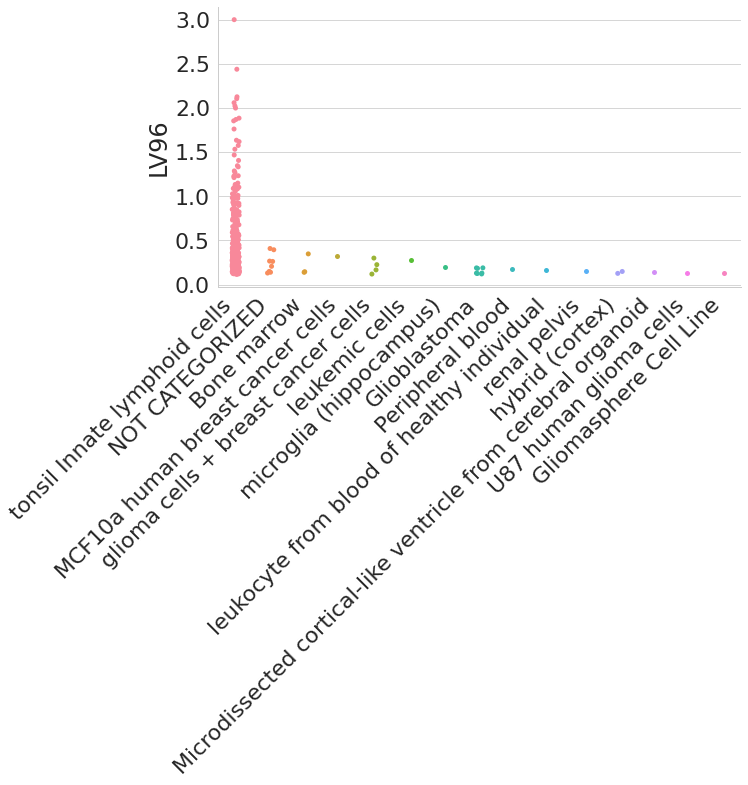

In [42]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

In [43]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
    display(_tmp.head(20))

cell type      LV96
project   run                                  
SRP056049 SRR1909145  NOT CATEGORIZED  0.409300
          SRR1909144  NOT CATEGORIZED  0.395039
          SRR1909143  NOT CATEGORIZED  0.266785
SRP064464 SRR2558141  NOT CATEGORIZED  0.262921
SRP056049 SRR1909141  NOT CATEGORIZED  0.207608
SRP018853 SRR765025   NOT CATEGORIZED  0.150161
SRP050499 SRR2013693  NOT CATEGORIZED  0.140403
          SRR2013705  NOT CATEGORIZED  0.131629

In [98]:
# # what is there in these projects?
# lv_data.loc[["SRP056041"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)